## Module Import

In [4]:
# self defined Modules
from myModules.plot.plotNetwork import Network

# General Modules
import warnings
import pickle

warnings.filterwarnings('ignore')

In [1]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm.notebook import tqdm
import pandas as pd
import operator
import numpy as np
from nltk import bigrams, ConditionalFreqDist
import matplotlib.font_manager as fm
from matplotlib import rc

import re

## Data Load

In [2]:
DATA_ROOT = './processed-data/'

PERIOD_1 = DATA_ROOT + 'period-1/ST/'
PERIOD_2 = DATA_ROOT + 'period-2/ST/'
PERIOD_3 = DATA_ROOT + 'period-3/ST/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [5]:
with open(PERIOD_1+"lemmatized-all.pkl", "rb") as f:
    all_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-noun.pkl", "rb") as f:
    noun_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-verb.pkl", "rb") as f:
    verb_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-adjective.pkl", "rb") as f:
    adjective_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-adverb.pkl", "rb") as f:
    adverb_1 = pickle.load(f)


with open(PERIOD_2+"lemmatized-all.pkl", "rb") as f:
    all_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-noun.pkl", "rb") as f:
    noun_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-verb.pkl", "rb") as f:
    verb_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-adjective.pkl", "rb") as f:
    adjective_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-adverb.pkl", "rb") as f:
    adverb_2 = pickle.load(f)

with open(PERIOD_3+"lemmatized-all.pkl", "rb") as f:
    all_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-noun.pkl", "rb") as f:
    noun_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-verb.pkl", "rb") as f:
    verb_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-adjective.pkl", "rb") as f:
    adjective_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-adverb.pkl", "rb") as f:
    adverb_3 = pickle.load(f)

In [67]:
class Network_v2:
    def __init__(self, data, keywords=['america', 'soviet']):
        # token을 bigram으로
        bgrams = [bigrams(tokens) for tokens in data]

        # bigram 객체를 튜플들의 list 형태로 변환
        token = []
        for bgram in bgrams:
            token += ([x for x in bgram])

        # ConditionalFreqDist 클래스를 이용하여 bigram으로 부터 frequency dist 계산
        cfd = ConditionalFreqDist(token)
        freq_mat = []

        # frequency dist 객체를 Pandas dataframe으로 제작
        for i in tqdm(cfd.keys(), desc="Generate Frequency Dist"):
            temp = []
            for j in cfd.keys():
                temp.append(cfd[i][j])
            freq_mat.append(temp)
        freq_mat = np.array(freq_mat)
        self.freq_df = pd.DataFrame(freq_mat, index=cfd.keys(), columns=cfd.keys())

        # keywords를 포함하여 Network에 이용한 row들의 index저장을 위해 copy
        valid_idx = keywords.copy()

        # keywords에 해당하는 row만을 freq_dist에서 추출
        tmp = self.freq_df.loc[keywords, :]

        # 살펴보면서 해당 keywords들과 freq 값이 계산되어있는 token들을 valid idx에 추가
        for idx in keywords:
            valid_idx.extend(tmp.loc[idx, tmp.loc[idx, :] > 0].index)

        relation_list = valid_idx.copy()

        try : relation_list.remove('soviet')
        except : pass

        try : relation_list.remove('america')
        except : pass

        relation_map = [('america', 'america'), ('soviet', 'soviet')]

        for row_idx in relation_list:
            if self.freq_df[row_idx]['america'] > self.freq_df[row_idx]['soviet']:
                relation_map.append((row_idx, 'america'))
            elif self.freq_df[row_idx]['america'] < self.freq_df[row_idx]['soviet']:
                relation_map.append((row_idx, 'soviet'))
            else : 
                relation_map.append((row_idx, 'neutral'))


        relation_with_america = {}
        relation_with_soviet = {}
        for idx, relation in relation_map:
            if relation == 'america':
                relation_with_america[idx] = self.freq_df.loc[idx, :].max()
            elif relation == 'soviet':
                relation_with_soviet[idx] = self.freq_df.loc[idx, :].max()

        sorted_relation_with_america = sorted(relation_with_america.items(), key = lambda item : item[1], reverse=True)
        sorted_relation_with_soviet = sorted(relation_with_soviet.items(), key = lambda item : item[1], reverse=True)

        try : top_N_america = sorted_relation_with_america[:10]
        except : top_N_america = sorted_relation_with_america[:]

        try : top_N_soviet = sorted_relation_with_soviet[:10]
        except : top_N_soviet = sorted_relation_with_soviet[:]

        top_N = top_N_america.copy()
        top_N.extend(top_N_soviet)
        top_N = sorted(top_N, key= lambda item : item[1], reverse=True)

        self.top_N_idx = []

        for idx, _ in top_N:
            self.top_N_idx.append(idx)
        
        relation_list = self.top_N_idx.copy()

        try : relation_list.remove('soviet')
        except : pass

        try : relation_list.remove('america')
        except : pass

        self.relation_map = [('america', 'america'), ('soviet', 'soviet')]

        for row_idx in relation_list:
            if self.freq_df[row_idx]['america'] > self.freq_df[row_idx]['soviet']:
                self.relation_map.append((row_idx, 'america'))
            elif self.freq_df[row_idx]['america'] < self.freq_df[row_idx]['soviet']:
                self.relation_map.append((row_idx, 'soviet'))
            else : 
                self.relation_map.append((row_idx, 'neutral'))

    def remove(self, token):
        return re.sub("[^a-z'\ ]", "", token)

    def remove_dot(self, data):
        result = []

        for tokens in data:
            temp = []
            for token in tokens:
                if "." in token : temp.append(self.remove(token))
                else : temp.append(token)
            result.append(temp)
        
        return result
    
    def generate_network(self):
        self.G = nx.from_pandas_adjacency(self.freq_df.loc[self.top_N_idx, :])

        dgr = nx.degree_centrality(self.G)
        self.dgr = sorted(dgr.items(), key=operator.itemgetter(1), reverse=True)

        cls = nx.closeness_centrality(self.G)
        self.cls = sorted(cls.items(), key=operator.itemgetter(1), reverse=True)

        btw = nx.betweenness_centrality(self.G)
        self.btw = sorted(btw.items(), key=operator.itemgetter(1), reverse=True)

        eig = nx.eigenvector_centrality(self.G)
        self.eig = sorted(eig.items(), key=operator.itemgetter(1), reverse=True)
    
    def plot(self, centrality='degree', title='Semantic Network Analysis', root='./'):
        if centrality == 'degree':
            title = title + ' (Degree)'
            centrality_value = self.dgr
        elif centrality == 'closeness':
            title = title + ' (Closeness)'
            centrality_value = self.cls
        elif centrality == 'betweenness':
            title = title + ' (Betweenness)'
            centrality_value = self.btw
        elif centrality == 'eigenvector':
            title = title + ' (Eigenvector)'
            centrality_value = self.eig

        for token, central in centrality_value:
            self.G.nodes[token]['weight'] = central

        for token, relation_val in self.relation_map:
            self.G.nodes[token]['relation'] = relation_val

        fig = plt.figure(figsize=(30, 20))
        plt.margins(x=0.1, y=0.2)
        plt.rc('font', family='Malgun Gothic')
        font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
        rc('font', family=font_name)
        ax = fig.gca()

        # edge와 node의 label 부여하기
        node_labels = dict((token, token) for token, _ in self.G.nodes(data=True))
        try :
            pos = graphviz_layout(self.G, prog='neato')
        except : 
            pos = nx.layout.fruchterman_reingold_layout(self.G)
            # pos = nx.shell_layout(self.G)
            # pos = nx.kamada_kawai_layout(self.G)
            # pos = nx.random_layout(self.G)
        nx.draw_networkx_labels(self.G, pos, font_family=font_name, labels=node_labels)

        # Node에 centrality에 따라 weight 부여
        Blues_modified = cm.get_cmap('Blues', 256)
        bluescmp = ListedColormap(Blues_modified(np.linspace(0.2, 0.8, 4)))
        nc_blues = nx.draw_networkx_nodes(self.G, pos,
            nodelist = [node[0] for node in self.G.nodes(data=True) if node[1]['relation'] == 'america'], 
            node_size=[node[1]["weight"]*20000 for node in self.G.nodes(data=True) if node[1]['relation'] == 'america'],
            node_color=[node[1]['weight'] for node in self.G.nodes(data=True) if node[1]['relation'] == 'america'], 
            cmap=bluescmp, node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # Node에 centrality에 따라 weight 부여
        Reds_modified = cm.get_cmap('Reds', 256)
        redscmp = ListedColormap(Reds_modified(np.linspace(0.2, 0.8, 4)))
        nc_reds = nx.draw_networkx_nodes(self.G, pos,
            nodelist = [node[0] for node in self.G.nodes(data=True) if node[1]['relation'] == 'soviet'], 
            node_size=[node[1]["weight"]*20000 for node in self.G.nodes(data=True) if node[1]['relation'] == 'soviet'],
            node_color=[node[1]['weight'] for node in self.G.nodes(data=True) if node[1]['relation'] == 'soviet'], 
            cmap=redscmp, node_shape='o', alpha=0.9, linewidths=0.4, edgecolors='#000000')

        # Edge에 co-occurrence에 따라 weight 부여
        Greys_modified = cm.get_cmap('Greys', 256)
        newcmp = ListedColormap(Greys_modified(np.linspace(0.2, 1.0, 4)))
        ec = nx.draw_networkx_edges(self.G, pos, 
            edge_color=[edge[2]['weight'] for edge in self.G.edges(data=True)],
            edge_cmap=newcmp, style='solid', width=2)

        # Title 설정
        plt.title(title, fontsize=25)
        plt.axis('off')

        axins = inset_axes(ax,
                    width='1%',
                    height='30%',
                    loc='center right',
                    borderpad=0)
        cbar = plt.colorbar(nc_blues, cax=axins)
        cbar.ax.set_ylabel('Centrality (America)', rotation=270, fontsize=12, labelpad=15)

        axins = inset_axes(ax,
                    width='1%',
                    height='30%',
                    loc='upper right',
                    borderpad=0)
        cbar = plt.colorbar(nc_reds, cax=axins)
        cbar.ax.set_ylabel('Centrality (Soviet)', rotation=270, fontsize=12, labelpad=15)

        axins = inset_axes(ax,
            width='1%',
            height='30%',
            loc='lower right',
            borderpad=0)
        cbar = plt.colorbar(ec, cax=axins)
        cbar.ax.set_ylabel('Word Pair Freqency', rotation=270, fontsize=12, labelpad=15)

        plt.savefig(root+title+'.png')
        plt.show()

    def save_centrality_table(self, table_len=10, title='centrality_table', root='./'):
        dgr_df = pd.DataFrame(self.dgr)
        cls_df = pd.DataFrame(self.cls)
        btw_df = pd.DataFrame(self.btw)
        eig_df = pd.DataFrame(self.eig)
        centrality_df = pd.concat([dgr_df, cls_df, btw_df, eig_df], axis=1)
        centrality_df.columns = ['Word', 'Degree Centrality', 'Word', 'Closeness Centrality', \
            'Word', 'Betweenness Centrality', 'Word', 'Eigenvector Centrality']
        centrality_df[:table_len].to_csv(root+title+'.csv')
        return centrality_df[:table_len]

In [68]:
network = Network_v2(data=noun_1)

network.generate_network()

Generate Frequency Dist:   0%|          | 0/3833 [00:00<?, ?it/s]

In [73]:
network.save_centrality_table()

,Word,Degree Centrality,Word,Closeness Centrality,Word,Betweenness Centrality,Word,Eigenvector Centrality
0,soviet,0.894737,soviet,0.826087,soviet,0.154353,people,0.343277
1,people,0.894737,people,0.826087,people,0.120303,soviet,0.325233
2,war,0.789474,war,0.760000,war,0.083120,war,0.303114
3,america,0.736842,america,0.730769,america,0.060540,state,0.296102
4,state,0.736842,state,0.730769,state,0.058104,america,0.285702
5,germany,0.684211,russia,0.730769,russia,0.031983,germany,0.284631
6,russia,0.631579,germany,0.703704,germany,0.029695,russia,0.281349
7,fact,0.631579,fact,0.678571,ministry,0.015302,fact,0.274736
8,man,0.526316,man,0.633333,plant,0.014327,nation,0.228288
9,nation,0.421053,nation,0.633333,fact,0.012408,man,0.220236


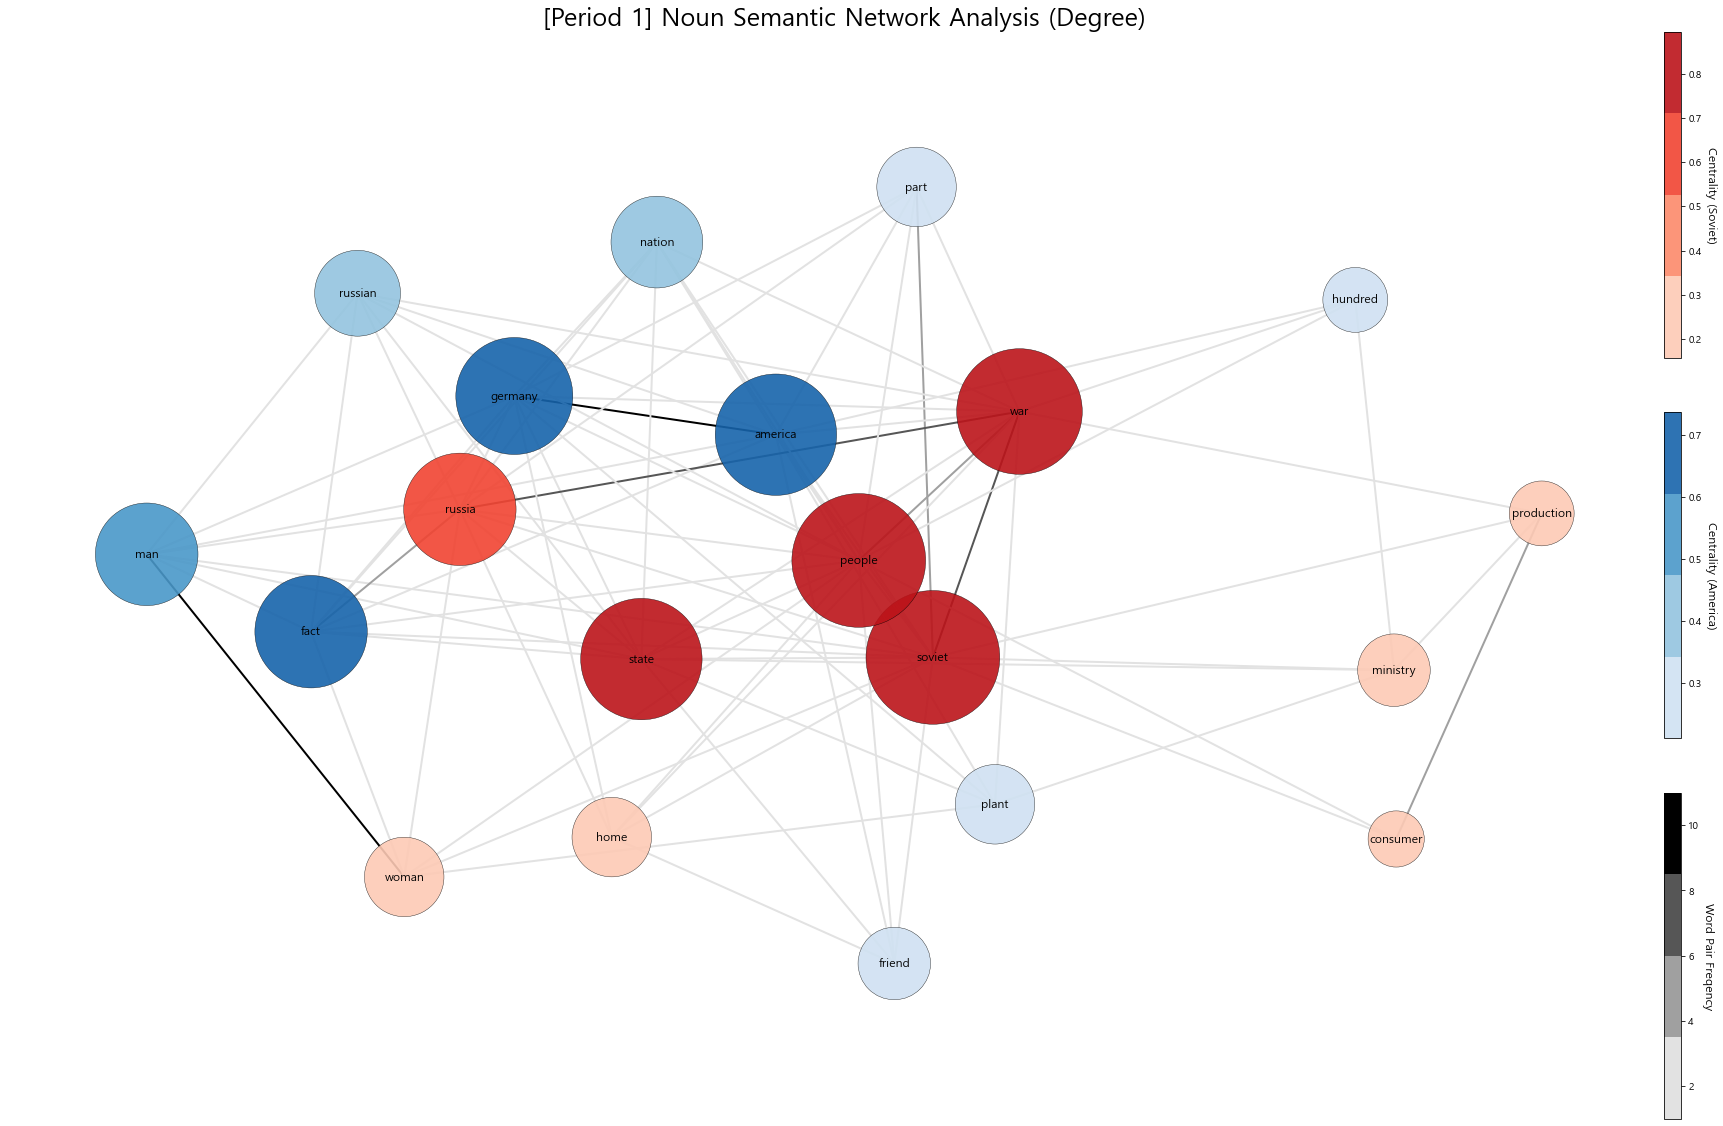

In [69]:
network.plot(centrality='degree', title="[Period 1] Noun Semantic Network Analysis")

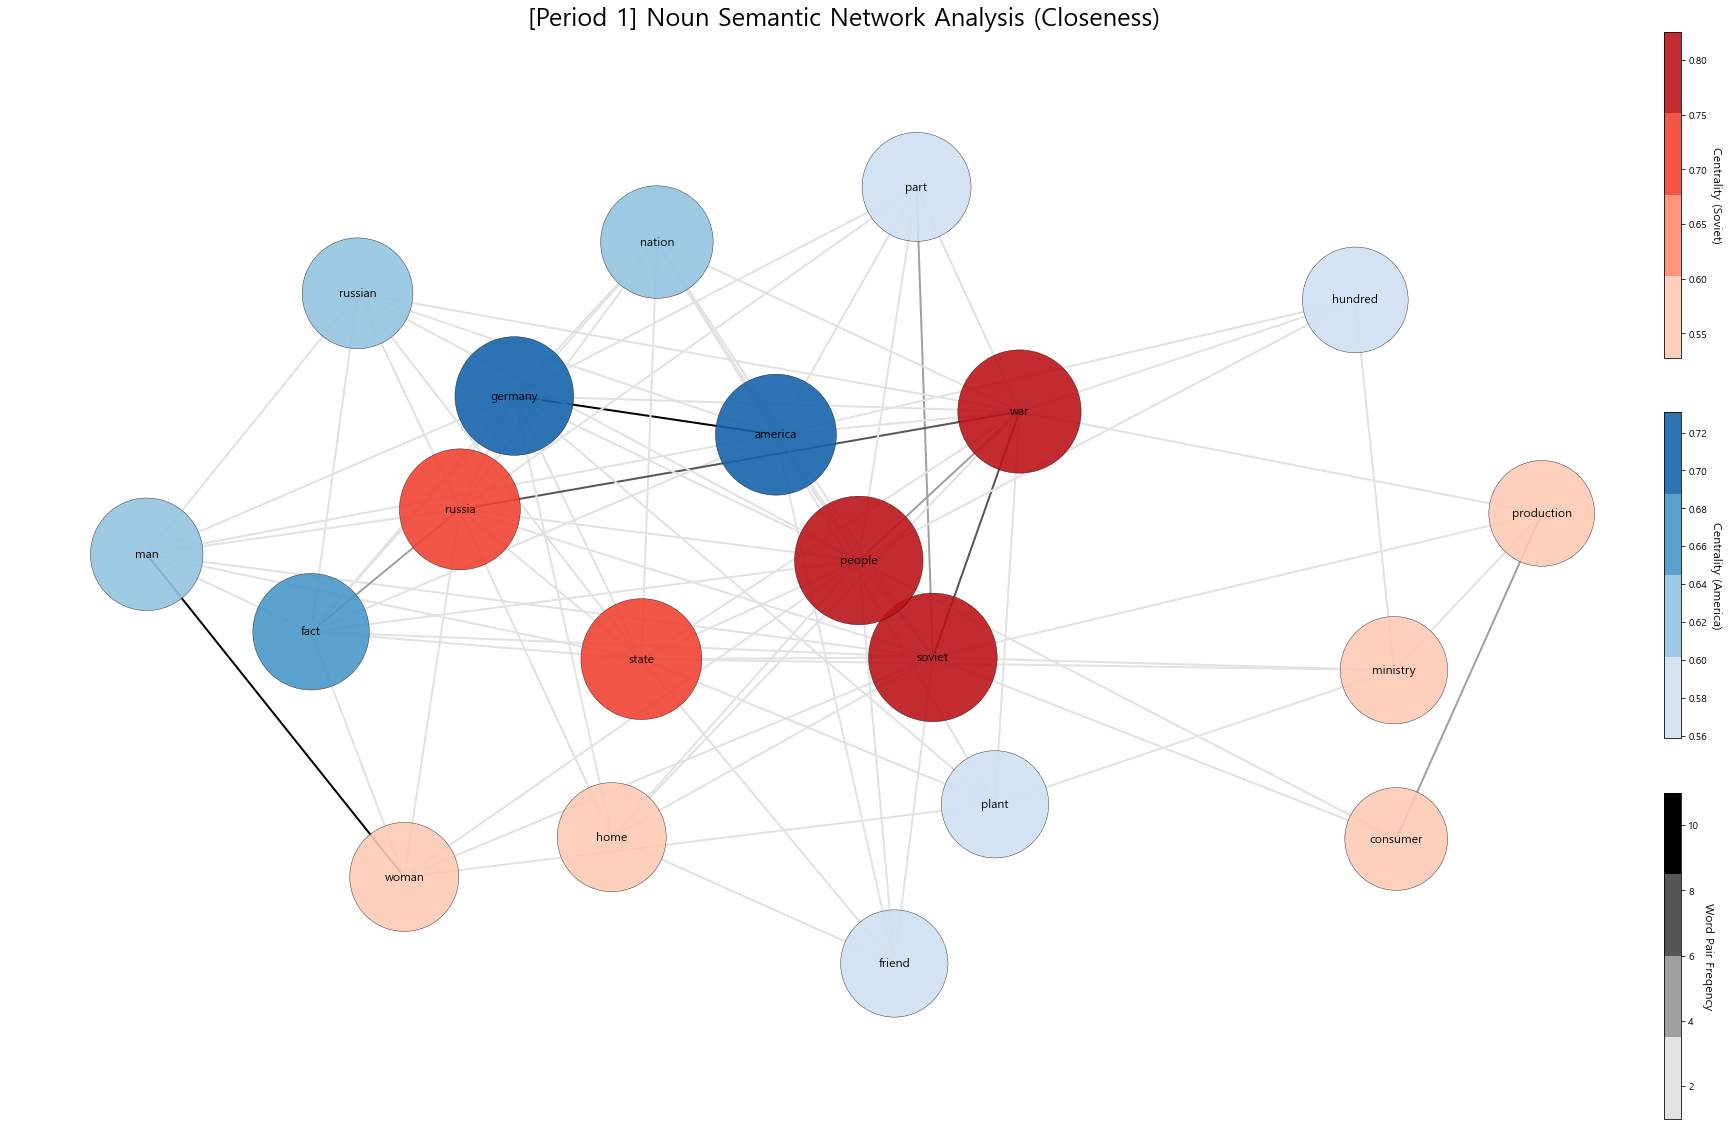

In [70]:
network.plot(centrality='closeness', title="[Period 1] Noun Semantic Network Analysis")

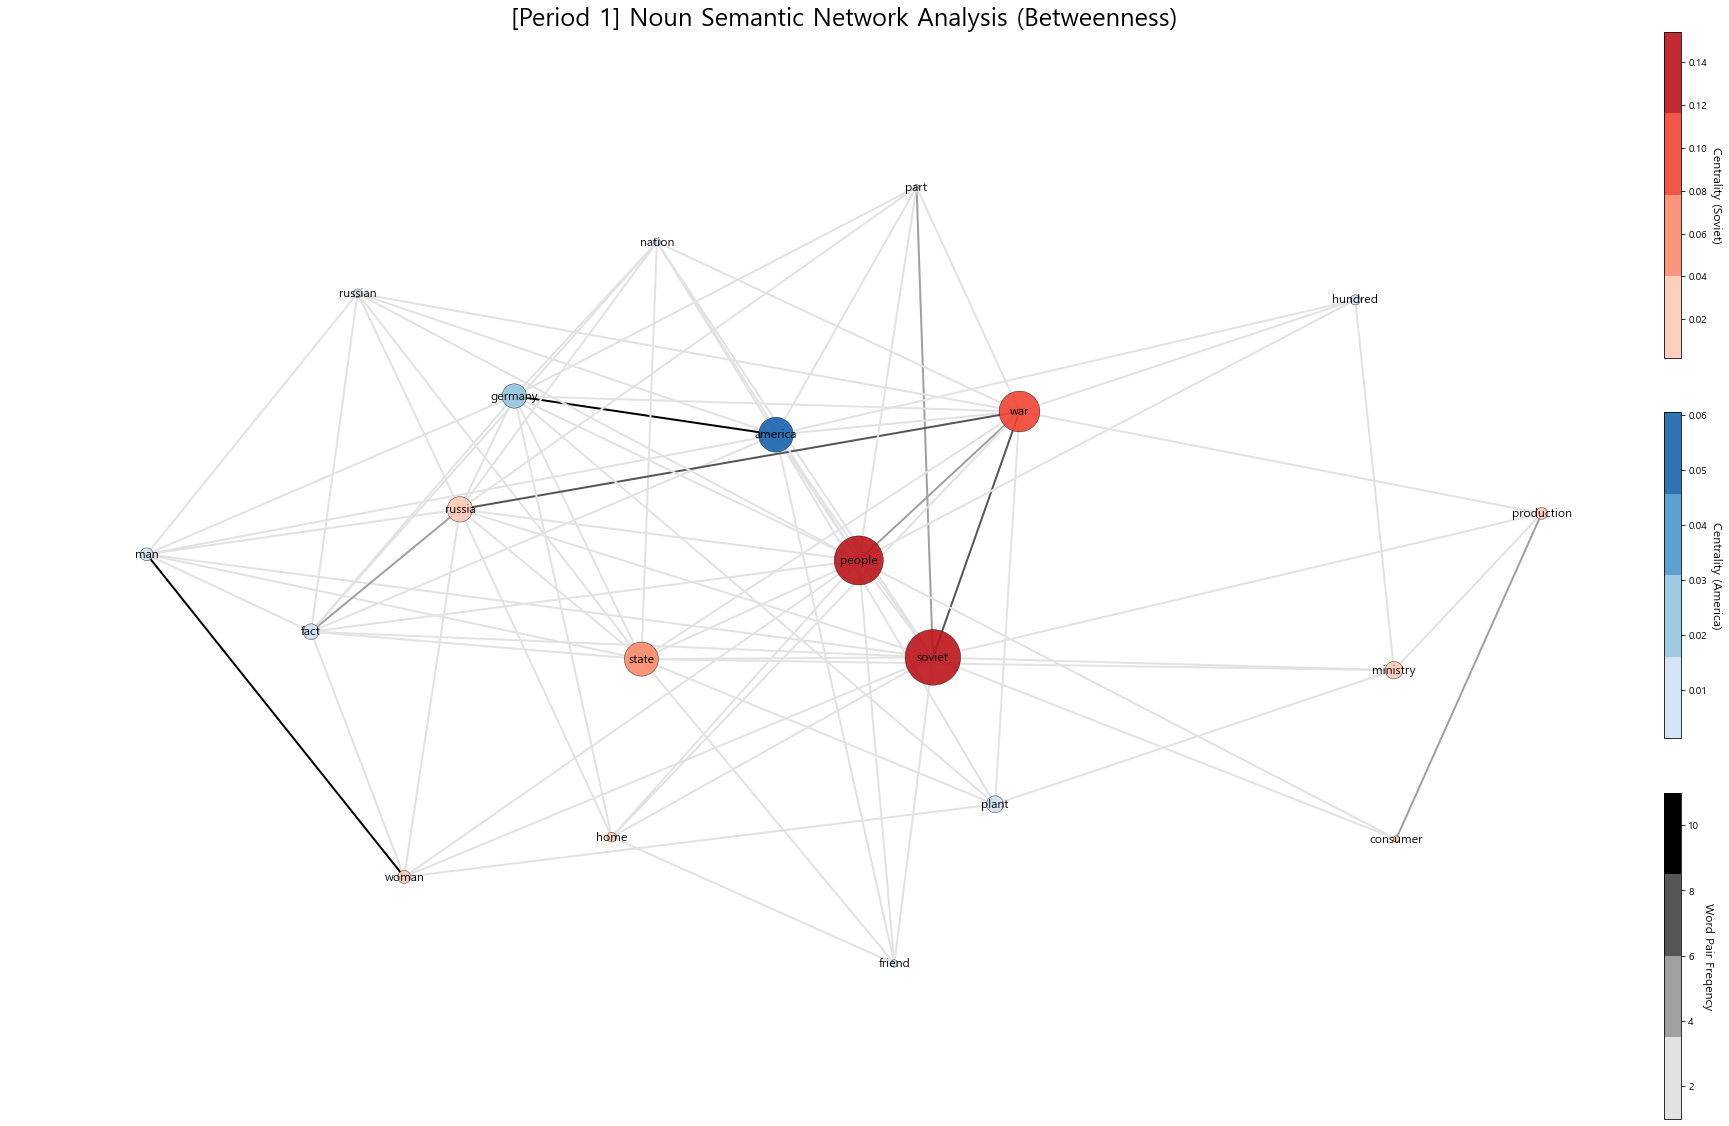

In [71]:
network.plot(centrality='betweenness', title="[Period 1] Noun Semantic Network Analysis")

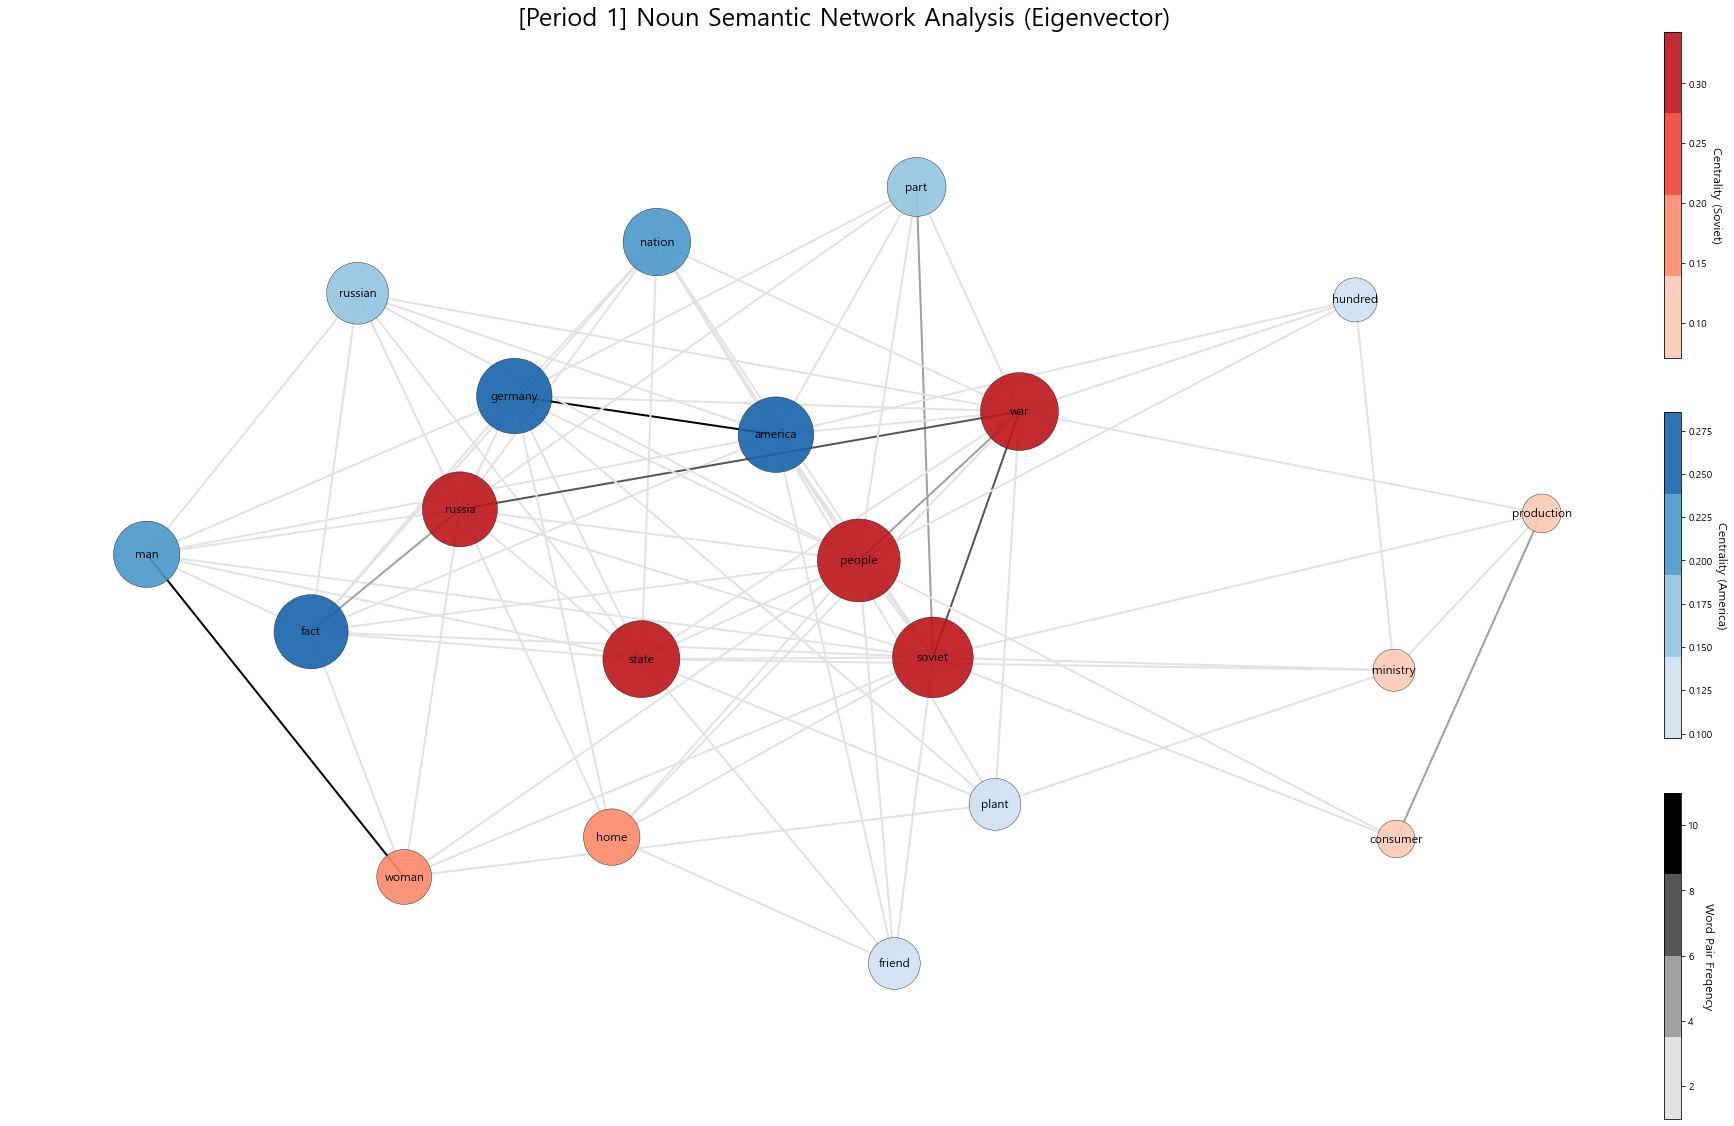

In [72]:
network.plot(centrality='eigenvector', title="[Period 1] Noun Semantic Network Analysis")